# Schrodinger Equation Solutions


Time dependent Schrodinger equation for the complex wave function $\psi(x,t)$, with $h^{2} / 2m = 1$ ...



$$ i \frac{\partial \psi(x,t)}{\partial t} = - \frac{\partial^{2} \psi(x,t)}{\partial x^{2}} + V(x) \psi(x,t)  $$

We have an electron in a well which is initially located around $x=5$ moving with momentum $k_{0}$,

$$ \psi(x,t=0) = e^{-\frac{1}{2} (\frac{x - 5}{\sigma_{0}})^{2}} e^{i k_{0} x} $$

Our Hamiltonian assumes the form 

$$ H = -\nabla^{2} + V(x) $$



### Method 1

Define 

$$ M = \left(1 - \frac{dt}{2i} H \right)^{-1} \left(1 + \frac{dt}{2i} H \right) $$

So we have

$$ \psi(x,t+dt) = M \cdot \psi(x,t) $$

### Method 2

For a time-independent Hamiltonian the analytic solution to the TDSE is given by

$$\psi(t)=e^{-\frac{i}{\hbar} H t} \psi_{0}$$

where $\psi_{0}$ is the initial state and $\hat{H}$ is the Hamiltonian matrix. A simple way of time stepping in this case is then NumPy's expm() function, which is used as a propagator. The function of a propagator is the propagation (in time) of the function it is applied to. In this case the solution is analytic, and thus the order of accuracy is infinity.




In [1]:
import os
import time
import warnings
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from scipy.sparse import linalg as ln
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
from scipy.linalg import expm, sinm, cosm

warnings.filterwarnings('ignore')

plt.rc('font', family='serif')
plt.rc('xtick',labelsize=18)
plt.rc('ytick',labelsize=18)
# %config InlineBackend.figure_format = 'retina'

In [2]:
def gaussian(x, σ, k0, x0=5):
    return np.exp(-0.5 * ((x - x0) / σ) ** 2) * np.exp(1j * k0 * x) 


def free(npts):
    "Free particle."
    return np.zeros(npts)


def barrier(npts,v0,thickness, offset=0):
    "Barrier potential (also a well)"
    v = free(npts)
    v[int(offset+npts/2):int(offset+npts/2+thickness)] = v0
    return v


def triangle(npts, vmax, width, offset=0):
    "Triangle potential"
    v = free(npts)
    A = (2*vmax)/npts  # slope 
    up_V = (np.arange(int(offset+(npts/2-width/2)),int(offset+npts/2))  - int(offset+(npts/2-width/2)))*A
    down_V = np.flip(np.arange(int(offset+npts/2), int(offset+(npts/2+width/2))) - int(offset+(npts/2)))*A
    v[int(offset+(npts/2-width/2)):int(offset+npts/2)] = up_V
    v[int(offset+npts/2):int(offset+npts/2+width/2)] = down_V
    return v


def half_triangle(npts, vmax, width, offset=0):
    "half triangle potential"
    v = free(npts)
    A = (2*vmax)/npts  # slope 
    up_V = (np.arange(int(offset+(npts/2-width/2)),int(offset+npts/2))  - int(offset+(npts/2-width/2)))*A
    down_V = np.flip(np.arange(int(offset+npts/2), int(offset+(npts/2+width/2))) - int(offset+(npts/2)))*A
    v[int(offset+(npts/2-width/2)):int(offset+npts/2)] = up_V
    v[int(offset+npts/2):int(offset+npts/2+width/2)] = up_V + up_V.max()
    return v


def SHO(npts, k, width, offset):
    """Harmonic oscillator potential"""
    v = free(npts)
    half = np.arange(int(offset+npts/2), int(offset+(npts/2+width/2))) - int(offset+(npts/2))
    up_curve = 0.5*k*half**2
    down_curve = np.flip(up_curve)
    v[int(offset+(npts/2-width/2)):int(offset+npts/2)] = down_curve
    v[int(offset+npts/2):int(offset+npts/2+width/2)] = up_curve
    v[int(offset+(npts/2-width/2)):int(offset+npts/2+width/2)] -=  v.max()
    return v
    

h = 1
m = 1
Δx = 1
Nx = 1400
σ0 = 30
x0 = round(Nx/2) - 10*σ0 # Time shift
k0 = np.pi / 20
# k0 = (m*v0)/h


""" 1) Space discretization """
x = np.linspace(0,Nx,Nx)
xmin = x.min()
xmax = x.max()


""" 2) Initialization of the wave function to Gaussian wave packet """
Ψ0 = gaussian(x=x, σ=σ0, k0=k0, x0=x0)
Ψ0_R = Ψ0.real
Ψ0_I = Ψ0.imag
ΨP = Ψ0_R**2 + Ψ0_I**2
P = ΨP.sum()
nrm = np.sqrt(P)
Ψ0 /= nrm
ΨP /= P


""" 3) Setting up the potential"""
# V = -triangle(npts=len(x), vmax=0.05, width=1400, offset=0)
V = barrier(npts=len(x), v0=0.015, thickness=50, offset = 0)
# V1 = -half_triangle(npts=len(x), vmax=0.05, width=600, offset=300)
# V2 = -np.flip(half_triangle(npts=len(x), vmax=0.05, width=600, offset=300))
# V3 = SHO(npts=len(x), k=2e-7, width=1400, offset=0) 
Vabsmax = np.abs(V.min()) if (V.max() == 0) else V.max()
Δt = h/((h**2/(m*Δx**2))+(Vabsmax/2))
    
""" 4) Creating the Hamiltonian """
H_diag = (h**2/(2*m*Δx**2)) * 2 * np.ones(Nx) + V
H_non_diag = (h**2/(2*m*Δx**2)) * -1 * np.ones(Nx - 1) 
H = sparse.diags([H_diag, H_non_diag, H_non_diag], [0, 1, -1])


""" Creating the time evolution matrix Using Method 1"""
A = sparse.eye(Nx) - Δt/2.0j * H
B = sparse.eye(Nx) + Δt/2.0j * H
M = ln.inv(A).dot(B)
M = M.toarray()


""" Creating the time evolution matrix Using Method 2"""
H = H.toarray()
U = expm(-1j*(H/h)*Δt)



ymax = 1.5*Ψ0_R.max()
Efac = 1.5*(Ψ0_R).max()/2.0/Vabsmax

E = (h**2/(2.0*m))*(k0**2+0.5/σ0**2)
KE = (h**2*k0**2)/(2*m)
print("Wavepacket Energy: {:.4f}".format(E))
print("Potential: {:.4f}".format(Vabsmax))
print("Δt = {:.4f}".format(Δt))
print("sum(ΨP) = {:.4f}".format(ΨP.sum()))

Wavepacket Energy: 0.0126
Potential: 0.0150
Δt = 0.9926
sum(ΨP) = 1.0000


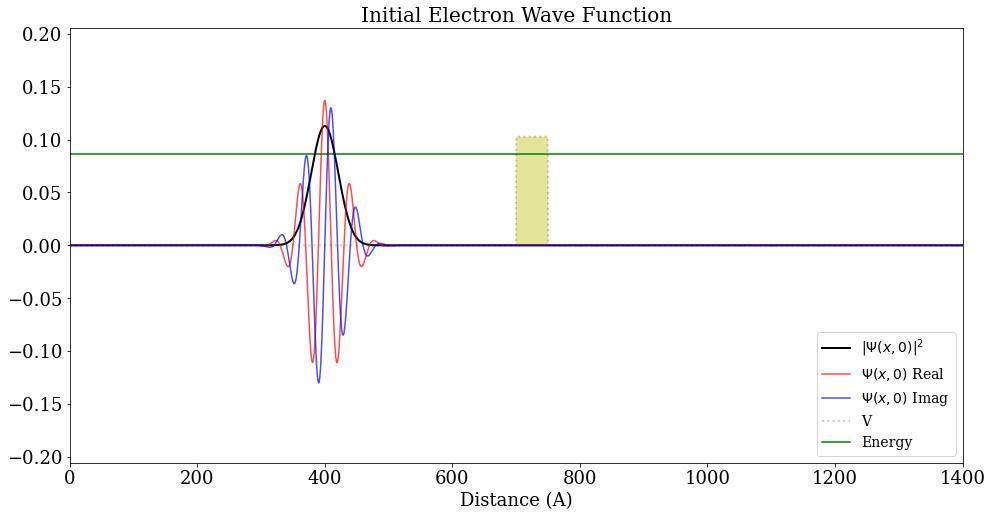

In [3]:
plt.figure(figsize=(16,8))
plt.axis([xmin,xmax,-ymax,ymax])
plt.title("Initial Electron Wave Function", fontsize=20)
plt.plot(x, 6*ΨP, 'k' , lw=2, label=r'$ | \Psi(x,0) |^{2} $')
plt.plot(x, Ψ0_R, 'r', alpha=0.7, label=r'$ \Psi(x,0) $ Real')
plt.plot(x, Ψ0_I, 'b', alpha=0.7, label=r'$ \Psi(x,0) $ Imag')
plt.plot(x, Efac*V, ':k', lw=2, alpha=0.2, label=r'V')
plt.axhline(E*Efac, color='g',label='Energy', zorder=1)
plt.fill_between(x,Efac*V, facecolor='y', alpha=0.4, zorder=0)
plt.xlabel("Distance (A)", fontsize=18)
plt.legend(prop={'size': 14}, loc="lower right")
plt.show()

In [4]:
class WavePacket:
    def __init__(self, Ψ, M, U):
        self.Ψ = Ψ
        self.M = M
        self.U = U
    
    def evolve_U(self):
        self.Ψ = self.U.dot(self.Ψ)
        ΨP = self.Ψ.real**2 + self.Ψ.imag**2
        return self.Ψ, ΨP
    
    def evolve_M(self):
        self.Ψ = self.M.dot(self.Ψ)
        ΨP = self.Ψ.real**2 + self.Ψ.imag**2
        return self.Ψ, ΨP

In [5]:
wave_packet = WavePacket(Ψ=Ψ0, M=M, U=U)

Nt = 10000

ΨR_arr = np.zeros((Nt, Nx))
ΨI_arr = np.zeros((Nt, Nx))
ΨP_arr = np.zeros((Nt, Nx))

start = time.time() 

for i in range(0, Nt):
    Ψ, ΨP = wave_packet.evolve_U()
    ΨR_arr[i] = Ψ.real
    ΨI_arr[i] = Ψ.imag
    ΨP_arr[i] = ΨP
    if (i % 50) == 0:
        clear_output(wait=True)
        print("Norm = {}".format(ΨP.sum()))
        print("Timestep {:.1f} / {:.1f}".format(i*Δt, Nt*Δt))
    
end = time.time()
print("\n{:.4f} seconds".format(end-start))

Norm = 0.9999999999958075
Timestep 9875.9 / 9925.6

12.7598 seconds


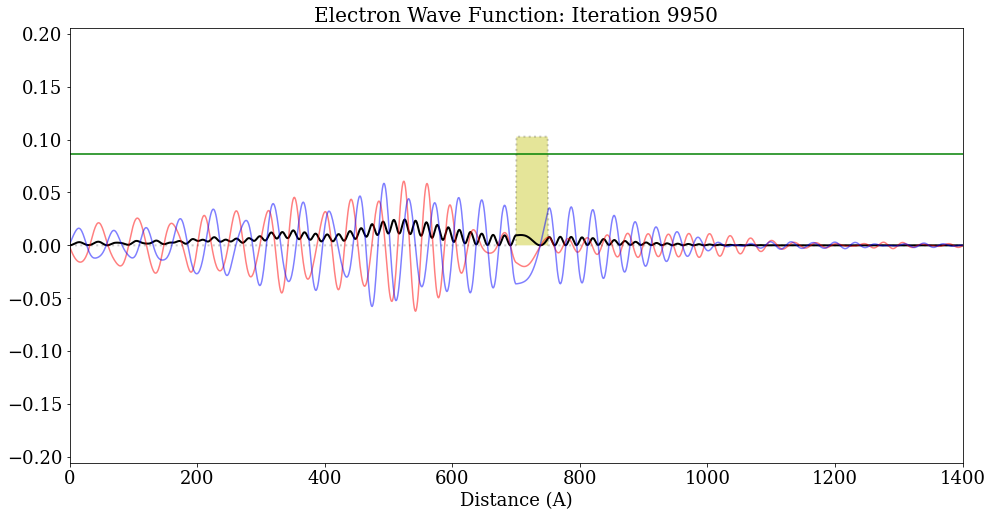

In [6]:
for i in range(0, Nt):
    if (i%50) == 0:
        plt.figure(figsize=(16,8))
        plt.axis([xmin,xmax,-ymax,ymax])
        plt.title("Electron Wave Function: Iteration {}".format(i), fontsize=20)
        plt.plot(x, 6*ΨP_arr[i], 'k' ,lw=2)
        plt.plot(x, ΨR_arr[i], 'r', alpha=0.5)
        plt.plot(x, ΨI_arr[i], 'b', alpha=0.5)
        plt.plot(x, Efac*V, ':k', lw=2, alpha=0.2)
        plt.axhline(E*Efac, color='g', zorder=1)
        plt.fill_between(x,Efac*V, facecolor='y', alpha=0.4, zorder=0)
        plt.xlabel("Distance (A)", fontsize=18)
        clear_output(wait=True)
        display(plt.gcf())
        plt.close()  

In [7]:
wave_packet = WavePacket(Ψ=Ψ0, M=M, U=U)

Nt = 10000

ΨR_arr = np.zeros((Nt, Nx))
ΨI_arr = np.zeros((Nt, Nx))
ΨP_arr = np.zeros((Nt, Nx))

start = time.time() 
for i in range(0, Nt):
    Ψ, ΨP = wave_packet.evolve_M()
    ΨR_arr[i] = Ψ.real
    ΨI_arr[i] = Ψ.imag
    ΨP_arr[i] = ΨP
    if (i % 50) == 0:
        clear_output(wait=True)
        print("Norm = {}".format(ΨP.sum()))
        print("Timestep {:.5f} / {:.5f}".format(i*Δt, Nt*Δt))
    
    
end = time.time()
print("\n{:.4f} seconds".format(end-start))

Norm = 0.9999999999959261
Timestep 9875.93052 / 9925.55831

13.5298 seconds


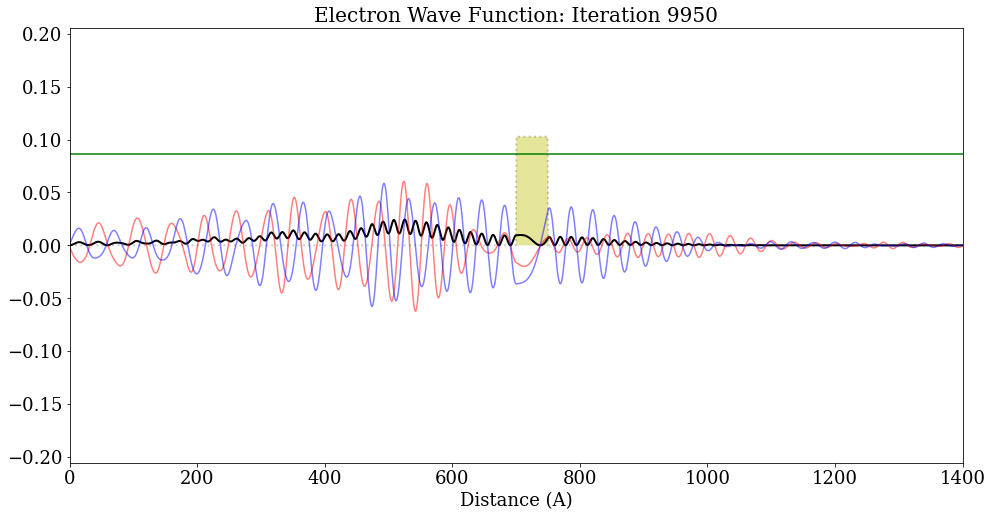

In [8]:
for i in range(0, Nt):
    if (i % 50) == 0:
        plt.figure(figsize=(16,8))
        plt.axis([xmin,xmax,-ymax,ymax])
        plt.title("Electron Wave Function: Iteration {}".format(i), fontsize=20)
        plt.plot(x, 6*ΨP_arr[i], 'k' ,lw=2)
        plt.plot(x, ΨR_arr[i], 'r', alpha=0.5)
        plt.plot(x, ΨI_arr[i], 'b', alpha=0.5)
        plt.plot(x, Efac*V, ':k', lw=2, alpha=0.2)
        plt.axhline(E*Efac, color='g', zorder=1)
        plt.fill_between(x, Efac*V, facecolor='y', alpha=0.4, zorder=0)
        plt.xlabel("Distance (A)", fontsize=18)
        clear_output(wait=True)
        display(plt.gcf())
        plt.close()  

In [9]:
%%time

N_iter = 10000

wave_packet = WavePacket(Ψ=Ψ0, M=M, U=U)

fig = plt.figure(figsize=(16, 10), dpi=100)
sim_ax = plt.gca()
sim_ax.set_ylim(-ymax,ymax)
sim_ax.set_xlim(xmin,xmax)
sim_ax.set_title("Electron Wave Function", fontsize=22, y=1.01)

ΨP_plot, = sim_ax.plot([], [], 'k', lw=2)
ΨR_plot, = sim_ax.plot([], [], 'r', alpha=0.5)
ΨI_plot, = sim_ax.plot([], [], 'b', alpha=0.5)
V_plot, = sim_ax.plot([], [], ':k', alpha=0.5)


plt.axhline(E*Efac, color='g', zorder=1)
plt.fill_between(x,Efac*V, facecolor='y', alpha=0.4, zorder=0)


def init_anim():
    """Initialize the animation"""
    ΨP_plot.set_data([], [])
    ΨR_plot.set_data([], [])
    ΨI_plot.set_data([], [])
    V_plot.set_data([], [])
    return ΨP_plot, ΨR_plot, ΨI_plot, V_plot

    
def animate(i):
    """Advance the animation by one step and update the frame."""
    global wave_packet
    Ψ, ΨP = wave_packet.evolve_U()
     
    ΨP_plot.set_data(x, 6*ΨP)
    ΨR_plot.set_data(x, Ψ.real)
    ΨI_plot.set_data(x, Ψ.imag)
    V_plot.set_data(x, V)
    
    return ΨP_plot, ΨR_plot, ΨI_plot, V_plot


anim = FuncAnimation(fig, animate, frames=N_iter, interval=10, init_func=init_anim)
anim.save('src/schrodinger_1D.mp4', fps=500)
plt.close()

CPU times: user 48min 27s, sys: 1min 21s, total: 49min 49s
Wall time: 8min 23s


In [ ]:
anim